### Imports

In [7]:
import pickle
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import LlamaForCausalLM, AutoTokenizer

from dicl import dicl

## Load data

* We will be using expert trajectories from the HalfCheetah Mujoco environment for our demo. The dataset is provided in `src/dicl/data/`.

In [5]:
env_name = "HalfCheetah"
n_actions = 6  # number of actions in the HalfCheetah system
n_observations = 17  # number of observations in the HalfCheetah system
data_label = "expert"
data_path = Path("../src") / "dicl" / "data" / f"D4RL_{env_name}_{data_label}.csv"

# ICL parameters
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

* Pick DICL(s) or DICL(s,a) method through the number of features (choose `n_observations` for vICL).

In [6]:
# to use DICL-(s) or vICL, set include_actions to False.
# to use DICL-(s,a), set include_actions to True
include_actions = False
if include_actions:
    n_features = n_observations + n_actions
else:
    n_features = n_observations

* Sample an episode and extract an in-context trajectory `(n_timestamps, n_features)`

In [7]:
# load data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")

# find episodes beginnings. the restart column is equal to 1 at the start of
# an episode, 0 otherwise.
restart_index = n_observations + n_actions + 1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

## DICL

* Instantiate DICL
* Choose the number of components for PCA (set to half here)
* Dor vICL n_components has to be equal to n_features

In [8]:
llm_list = [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/43fa890183375f5f69cb9646f29aa99ef3207c22"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.1-8B/snapshots/8d10549bcf802355f2d6203a33ed27e81b15b9e5"
]
llm_list += [
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/"
]
llm_list += [
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.1-70B/snapshots/349b2ddb53ce8f2849a6c168a81980ab25258dac/"
]

# to use vICL, set vanilla_icl to True.
# to use DICL-(s,a) or DICL-(s), set vanilla_icl to False
vanilla_icl = True

result_dict = {}

n_episodes = 5
selected_episodes = np.random.choice(episode_starts, (n_episodes,))

for llm_model in tqdm(llm_list, desc='llm'):
    tokenizer = AutoTokenizer.from_pretrained(
        llm_model,
        use_fast=False,
    )
    model = LlamaForCausalLM.from_pretrained(
        llm_model,
        device_map="auto",
        torch_dtype=torch.bfloat16,
    )
    model.eval()
    
    for episode in selected_episodes:
        time_series = X[episode : episode + context_length, :n_features]
        if episode not in result_dict.keys():
            result_dict[episode] = {}
    
        if vanilla_icl:
            DICL = dicl.vICL(
                n_features=n_features,
                model=model,
                tokenizer=tokenizer,
                rescale_factor=rescale_factor,
                up_shift=up_shift,
            )
        else:
            DICL = dicl.DICL_PCA(
                n_features=n_features,
                n_components=int(n_features / 2),
                model=model,
                tokenizer=tokenizer,
                rescale_factor=rescale_factor,
                up_shift=up_shift,
            )
    
        DICL.fit_disentangler(X=time_series)
    
        mean, mode, lb, ub = DICL.predict_single_step(X=time_series)
    
        # print metrics
        burnin = 0
        single_step_metrics = DICL.compute_metrics(burnin=burnin)
    
        result_dict[episode][llm_model.split("--")[2].split('/')[0]] = single_step_metrics

llm:   0%|                                                                                                         | 0/5 [00:00<?, ?it/s]2024-10-17 14:58:02.741111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 14:58:02.759566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 14:58:02.780192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 14:58:02.786481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to regist

In [9]:
save_path = Path("../artifacts") / "ablation_llm_single_step_vicl.pkl"

with open(save_path, "wb") as outfile:
    pickle.dump(result_dict, outfile)

## Visualize

In [2]:
load_path = Path("../artifacts") / "ablation_llm_single_step_vicl.pkl"
with open(load_path, "rb") as infile:
    loaded_dict = pickle.load(infile)
loaded_dict.keys()

dict_keys([15000, 3000, 2000, 17000, 10000])

In [3]:
loaded_dict[2000].keys()

dict_keys(['Llama-3.2-1B', 'Llama-3.2-3B', 'Llama-3.1-8B', 'Meta-Llama-3-8B', 'Llama-3.1-70B'])

In [5]:
loaded_dict[2000]["Llama-3.2-1B"].keys()


dict_keys(['average_agg_squared_error', 'agg_squared_error', 'average_perdim_squared_error', 'perdim_squared_error', 'scaled_average_agg_squared_error', 'scaled_agg_squared_error', 'scaled_average_perdim_squared_error', 'scaled_perdim_squared_error', 'perdim_ks', 'agg_ks'])

In [12]:
loaded_dict[2000]["Llama-3.2-1B"]["scaled_average_perdim_squared_error"]

array([0.783987  , 0.57345126, 0.1679176 , 0.58267589, 0.61793155,
       0.26008066, 0.77781826, 0.6857869 , 0.07071621, 0.78129553,
       0.69910373, 0.25520311, 0.56503188, 0.85191779, 0.4285861 ,
       0.82282001, 0.91501746])

In [3]:
# Initialize a dictionary to store the errors for each LLM
llm_errors = {llm: [] for llm in loaded_dict[15000].keys()}

# Extract the scaled_average_agg_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        llm_errors[llm].append(
            loaded_dict[episode][llm]["scaled_average_agg_squared_error"]
        )

# Compute the mean and standard deviation for each LLM
llm_stats = {}
for llm, errors in llm_errors.items():
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    llm_stats[llm] = (mean_error, std_error)

# Print the table
print("LLM | Mean ± Std Dev")
print("-------------------")
for llm, (mean, std) in llm_stats.items():
    print(f"{llm} | {mean:.2f} ± {std:.2f}")


LLM | Mean ± Std Dev
-------------------
Llama-3.2-1B | 3.07 ± 0.05
Llama-3.2-3B | 3.14 ± 0.08
Llama-3.1-8B | 2.93 ± 0.09
Meta-Llama-3-8B | 2.65 ± 0.06
Llama-3.1-70B | 2.59 ± 0.08


In [5]:
# Dimension names
dim_names = [
    r"$rootz$",
    r"$rooty$",
    r"$bthigh$",
    r"$bshin$",
    r"$bfoot$",
    r"$fthigh$",
    r"$fshin$",
    r"$ffoot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{bthigh}$",
    r"$\dot{bshin}$",
    r"$\dot{bfoot}$",
    r"$\dot{fthigh}$",
    r"$\dot{fshin}$",
    r"$\dot{ffoot}$",
]

# Initialize a dictionary to store the errors for each LLM and each dimension
llm_errors = {llm: [[] for _ in range(17)] for llm in loaded_dict[15000].keys()}

# Extract the scaled_average_perdim_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        errors = loaded_dict[episode][llm]["scaled_average_perdim_squared_error"]
        for dim in range(17):
            llm_errors[llm][dim].append(errors[dim])

# Compute the mean and standard deviation for each LLM and each dimension
llm_stats = {}
for llm, errors in llm_errors.items():
    llm_stats[llm] = [
        (np.mean(dim_errors), np.std(dim_errors)) for dim_errors in errors
    ]

# Print the table header
print("Dimension | " + " | ".join(llm_errors.keys()) + " |")
print("--------- | " + " | ".join(["-" * 15 for _ in llm_errors.keys()]) + " |")

# Print the table rows
for dim in range(17):
    row = [dim_names[dim]]
    for llm in llm_errors.keys():
        mean, std = llm_stats[llm][dim]
        row.append(f"{mean:.2f} ± {std:.2f}")
    print(" | ".join(row) + " |")


Dimension | Llama-3.2-1B | Llama-3.2-3B | Llama-3.1-8B | Meta-Llama-3-8B | Llama-3.1-70B |
--------- | --------------- | --------------- | --------------- | --------------- | --------------- |
$rootz$ | 0.70 ± 0.06 | 0.76 ± 0.09 | 0.74 ± 0.08 | 0.68 ± 0.09 | 0.58 ± 0.06 |
$rooty$ | 0.61 ± 0.08 | 0.66 ± 0.08 | 0.59 ± 0.08 | 0.52 ± 0.07 | 0.39 ± 0.09 |
$bthigh$ | 0.15 ± 0.02 | 0.16 ± 0.03 | 0.17 ± 0.04 | 0.13 ± 0.03 | 0.10 ± 0.03 |
$bshin$ | 0.59 ± 0.04 | 0.54 ± 0.06 | 0.49 ± 0.03 | 0.39 ± 0.02 | 0.40 ± 0.05 |
$bfoot$ | 0.64 ± 0.04 | 0.66 ± 0.10 | 0.65 ± 0.05 | 0.55 ± 0.05 | 0.51 ± 0.06 |
$fthigh$ | 0.29 ± 0.03 | 0.34 ± 0.09 | 0.38 ± 0.20 | 0.20 ± 0.04 | 0.20 ± 0.07 |
$fshin$ | 0.74 ± 0.04 | 0.77 ± 0.03 | 0.58 ± 0.08 | 0.55 ± 0.07 | 0.47 ± 0.06 |
$ffoot$ | 0.67 ± 0.04 | 0.80 ± 0.04 | 0.81 ± 0.10 | 0.64 ± 0.07 | 0.64 ± 0.11 |
$\dot{rootx}$ | 0.07 ± 0.01 | 0.07 ± 0.01 | 0.07 ± 0.00 | 0.06 ± 0.01 | 0.06 ± 0.01 |
$\dot{rootz}$ | 0.83 ± 0.03 | 0.89 ± 0.03 | 0.89 ± 0.04 | 0.74 ± 0.03 | 0.75 ± 

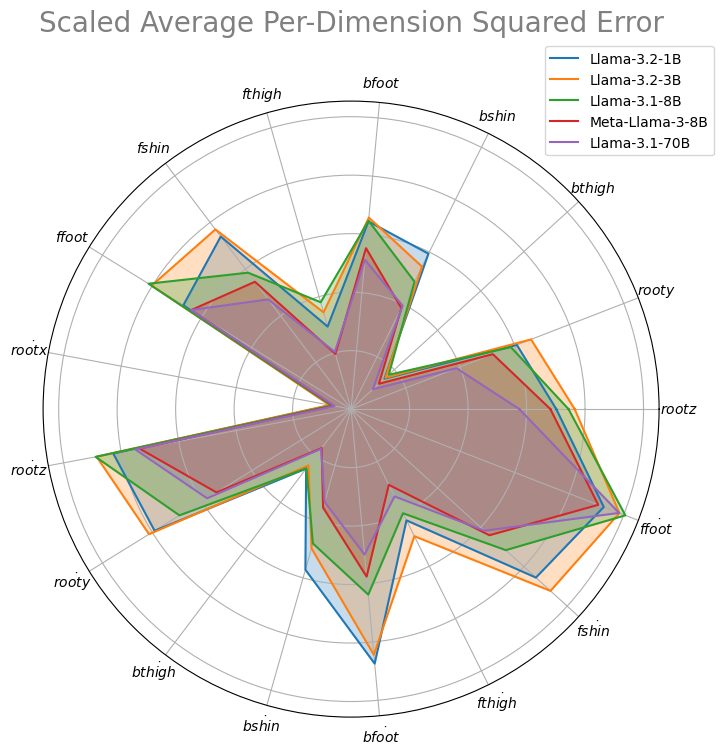

In [10]:
# Initialize a dictionary to store the errors for each LLM and each dimension
llm_errors = {llm: [[] for _ in range(17)] for llm in loaded_dict[15000].keys()}

# Extract the scaled_average_perdim_squared_error for each LLM across all episodes
for episode in loaded_dict:
    for llm in loaded_dict[episode]:
        errors = loaded_dict[episode][llm]["scaled_average_perdim_squared_error"]
        # errors = loaded_dict[episode][llm]["perdim_ks"]
        for dim in range(17):
            llm_errors[llm][dim].append(errors[dim])

# Compute the mean for each LLM and each dimension
llm_means = {}
for llm, errors in llm_errors.items():
    llm_means[llm] = [np.mean(dim_errors) for dim_errors in errors]


# Function to create a radar chart
def create_radar_chart(data, categories, title):
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for llm, values in data.items():
        values += values[:1]
        ax.fill(angles, values, alpha=0.25)
        ax.plot(angles, values, label=llm)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(title, size=20, color="gray", y=1.1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

    plt.show()


# Create the radar chart
create_radar_chart(llm_means, dim_names, "Scaled Average Per-Dimension Squared Error")
